# Load modules

In [1]:
# pip install seaborn

In [2]:
# pip install pyabc

In [3]:
# pip install xlrd

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy import stats
from IPython.display import Image
from functools import partial
import pickle
import pandas as pd
import seaborn as sns
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
import pyabc.visualization
from pyabc.visualization import plot_kde_2d

# Stem cell hierarchy

As Lan et al. proposed, a stem cell hierachy in Glioblastoma development consists of three different cell types: stem cell, progenitor cell and differentiated cell. As shown in Figure, a stem cell could divide into either two stem cells (symmetrical cell division) or one stem cell and one progenitor cell (asymmetrical cell division); a progenitor cell could either divide into two progenitor cells (cell division) or differentiate into one differentiated cell (cell division); and a differentiated cell will eventually undergo cell apoptosis.

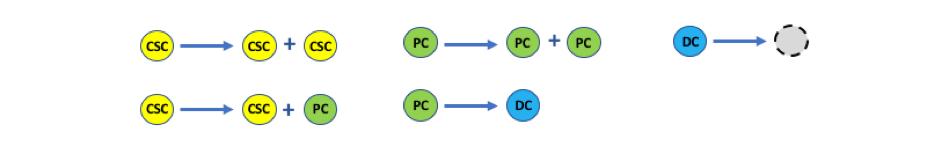

In [5]:
Image("Lan.png")

However, the stem cell hierarchy model lack presence of quiescent stem cell. Therefore, we propose a new model here

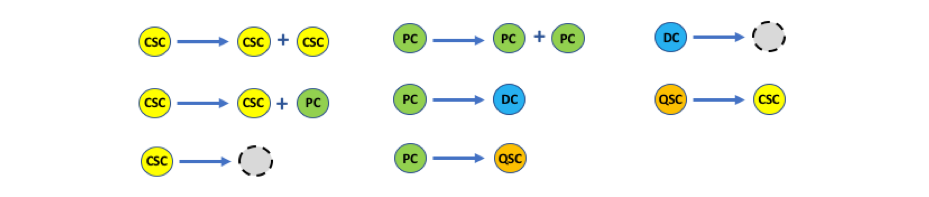

In [6]:
Image("new.png")

In the following clonalSizeSimulation/clonalGrowthSimulation, stochastic simulation is applied to five reactions:

    Reaction 1: S > S + S,    rate of reaction k1 
    Reaction 2: S > S + P,    rate of reaction k2 
    Reaction 3: S > none,     rate of reaction k3
    Reaction 4: P > P + P,    rate of reaction k4 = lambda * 0.5
    Reaction 5: P > D,        rate of reaction k5 = lambda * 0.5
    Reaction 6: P > Q,        rate of reaction k6
    Reaction 7: D > none,     rate of reaction k7 = gamma
    Reaction 8: Q > S,        rate of reaction k8

# Simulation for a single passage

In [7]:
parameters = {
    "k1":0.0225,
    "k2":0.1275,
    "lambda":1.0,
    "k7":0.48}

countingTimePoints = np.array([80,65,70])
    
testParameters = {
    "k3": 0.15,
    "k6": 0.15,
    "k8": 0.1
}

In [8]:
# def cellCount(reactionTime, cell, time):
#     time = range(int(time))
#     count = np.zeros(len(time))
#     for t in time:
#         cellIndex = np.array(np.where(reactionTime <= t)[0])
#         if cellIndex.size:
#             cellTimeIndex = np.array(cellIndex[-1])
#             count[t] = cell[cellTimeIndex]
#         else:
#             count[t] = cell[0]
#     return(count)

def clonalGrowth(inject, testParameters, time):
    k1 = parameters["k1"]
    k2 = parameters["k2"]
    k3 = testParameters["k3"]
    k4 = parameters["lambda"]*0.5
    k5 = parameters["lambda"]*0.5
    k6 = testParameters["k6"]
    k7 = parameters["k7"]
    k8 = testParameters["k8"]
    S = inject["stem"]
    P = inject["progenitor"]
    D = 0
    Q = inject["quiescent"]
    reactionTime = 0      
    cont = True  
    while(cont):
        A1 = S*k1
        A2 = S*k2
        A3 = S*k3
        A4 = P*k4
        A5 = P*k5
        A6 = P*k6
        A7 = D*k7
        A8 = Q*k8
        A0 = A1 + A2 + A3 + A4 + A5 + A6 + A7 + A8
#         first random number generator to determine the time of nexr reaction
        r1 = random.random()
        t = np.log(1/r1)/A0
        if reactionTime + t > time:
            cont = False
        else:
            reactionTime += t
#             second random number generator to determine which reaction occurs
            r2 = random.random()
            if r2 < A1/A0:
                S += 1
            elif r2 < (A1+A2)/A0:
                P += 1
            elif r2 < (A1+A2+A3)/A0:
                S -= 1
            elif r2 < (A1+A2+A3+A4)/A0:
                P += 1
            elif r2 < (A1+A2+A3+A4+A5)/A0:
                P -= 1
                D += 1
            elif r2 < (A1+A2+A3+A4+A5+A6)/A0:
                P -= 1
                Q += 1
            elif r2 < (A1+A2+A3+A4+A5+A6+A7)/A0:
                D -= 1
            else:
                S += 1
                Q -=1
    return{"stem":S,"progenitor":P,"differentiated":D,"quiescent":Q}


# Simulation for a serial passage

In [9]:
def transplantation(harvest,transplantationProb):
    stemHarvest = harvest["stem"]
    proHarvest = harvest["progenitor"]
    quieHarvest = harvest["quiescent"]
    totalHarvest = stemHarvest + proHarvest + quieHarvest
    stemReinject = 0
    proReinject = 0
    quieReinject = 0
    if totalHarvest > 0:
        stemProb = stemHarvest/totalHarvest
        proProb = proHarvest/totalHarvest
        quieProb = quieHarvest/totalHarvest
        stemReinject += np.random.binomial(n=totalHarvest, p=stemProb*transplantationProb)
        proReinject += np.random.binomial(n=totalHarvest, p=proProb*transplantationProb)
        quieReinject += np.random.binomial(n=totalHarvest, p=quieProb*transplantationProb)
    else:
        pass
    return{"stem":stemReinject, "progenitor":proReinject, "quiescent":quieReinject}

def passageExpansion(primaryInject, testParameters, transplantationProb, seed):
    np.random.seed(seed)
    primaryHarvest = clonalGrowth(primaryInject, testParameters,countingTimePoints[0])
    secondaryInject = transplantation(primaryHarvest,transplantationProb)
    secondaryHarvest = clonalGrowth(secondaryInject, testParameters,countingTimePoints[1])
    tertiaryInject = transplantation(secondaryHarvest,transplantationProb)
    tertiaryHarvest = clonalGrowth(tertiaryInject, testParameters,countingTimePoints[2])
    S = np.array([primaryHarvest["stem"],secondaryHarvest["stem"],tertiaryHarvest["stem"]])
    P = np.array([primaryHarvest["progenitor"],secondaryHarvest["progenitor"],tertiaryHarvest["progenitor"]])
    D = np.array([primaryHarvest["differentiated"],secondaryHarvest["differentiated"],tertiaryHarvest["differentiated"]])
    Q = np.array([primaryHarvest["quiescent"],secondaryHarvest["quiescent"],tertiaryHarvest["quiescent"]])
    return{"stem":S, "progenitor":P, "differentiated":D, "quiescent":Q}

# Simulation for multiple clones

In [10]:
def multiGrowthSimulation(testParameters):
    simulation = 1000
    s = np.random.binomial(n=simulation, p=0.17)
    p = np.random.binomial(n=simulation, p=0.64)
    timeRange = int(len(countingTimePoints))
    multiGrowth = np.zeros((simulation,4,timeRange))
    for i in range(simulation):
        if i < s:
            clone = passageExpansion({"stem":1,"progenitor":0,"quiescent":0}, testParameters, 0.37, i)
        elif i < (s + p):
            clone = passageExpansion({"stem":0,"progenitor":1,"quiescent":0}, testParameters, 0.37, i)
        else:
            clone = passageExpansion({"stem":0,"progenitor":0,"quiescent":1}, testParameters, 0.37, i)
        multiGrowth[i][0][:] = clone["stem"]
        multiGrowth[i][1][:] = clone["progenitor"]
        multiGrowth[i][2][:] = clone["differentiated"]
        multiGrowth[i][3][:] = clone["quiescent"]
    return(multiGrowth)

def barFreqDistribution(testParameters):
    multiGrowth = multiGrowthSimulation(testParameters)
    clones = len(multiGrowth)
    primary = np.zeros(clones)
    secondary = np.zeros(clones)
    tertiary = np.zeros(clones)
    for clone in range(clones):
        primary[clone] = sum(np.array([multiGrowth[clone][cellType][0] for cellType in range(4)]))
        secondary[clone] = sum(np.array([multiGrowth[clone][cellType][1] for cellType in range(4)]))
        tertiary[clone] = sum(np.array([multiGrowth[clone][cellType][2] for cellType in range(4)]))
    primaryBarFreq = primary/sum(primary)
    secondaryBarFreq = secondary/sum(secondary)
    tertiaryBarFreq = tertiary/sum(tertiary)
    return{"primary":primaryBarFreq, "secondary":secondaryBarFreq, "tertiary": tertiaryBarFreq}


In [11]:
# %time multiGrowth = multiGrowthSimulation(testParameters)

In [12]:
%time barFreqSim = barFreqDistribution(testParameters)

CPU times: user 207 ms, sys: 2.22 ms, total: 209 ms
Wall time: 208 ms


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


# search for parameters by comparing with Lan et al.'s experimental data

In [13]:
experiment = pd.read_excel("Table_1_experimental_clonal_size.xlsx")
experiment.head()

,Barcode,(1)719 Ipsi,(1)719 Contra,"(1,1V)719 Ipsi","(1,1V)719 Contra","(1,2V)719 Ipsi","(1,2V)719 Contra","(1,3V)719 Ipsi","(1,3V)719 Contra","(1,1T)719 Ipsi",...,"(1,1T,1V)719 Ipsi","(1,1T,1V)719 Contra","(1,1T,2V)719 Ipsi","(1,1T,2V)719 Contra","(1,1T,1T)719 Ipsi","(1,1T,1T)719 Contra","(1,1T,2T)719 Ipsi","(1,1T,2T)719 Contra","(1,1T,3T)719 Ipsi","(1,1T,3T)719 Contra"
0,AAATCAAGATCGAAACTGGTCAAACTG,0.001608,0.000614,0.002460,0.002479,0.002866,0.001103,0.004939,0.006328,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.005538,0.0,0.0,0.003078
1,AAATCAGGATGCAAACAGGTGTAACGG,0.001913,0.002575,0.003878,0.004407,0.003090,0.003762,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,AAATCCAGATCGAAATGGGTTTAACTT,0.002520,0.000000,0.005109,0.003288,0.005141,0.000000,0.002147,0.002167,0.00199,...,0.000000,0.0,0.003741,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,AAATCCAGATGGAAAGAGGTAGAACCC,0.001200,0.000743,0.001532,0.001386,0.002106,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,AAATCTCGATGGAAATCGGTCAAACAA,0.002975,0.001134,0.004104,0.002142,0.009155,0.001001,0.009424,0.010710,0.00199,...,0.002222,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [14]:
np.shape(experiment)

(2070, 39)

In [15]:
passage = experiment.columns
passage[1:]

Index(['(1)719 Ipsi', '(1)719 Contra', '(1,1V)719 Ipsi', '(1,1V)719 Contra',
       '(1,2V)719 Ipsi', '(1,2V)719 Contra', '(1,3V)719 Ipsi',
       '(1,3V)719 Contra', '(1,1T)719 Ipsi', '(1,1T)719 Contra',
       '(1,2T)719 Ipsi', '(1,2T)719 Contra', '(1C,1)719 Ipsi',
       '(1C,1)719 Contra', '(1C,2)719 Ipsi', '(1C,2)719 Contra',
       '(1,2V,1)719 Ipsi', '(1,2V,1)719 Contra', '(1,2V,2)719 Ipsi',
       '(1,2V,2)719 Contra', '(1,2V,3)719 Ipsi', '(1,2V,3)719 Contra',
       '(1,3V,1V)719 Ipsi', '(1,3V,1V)719 Contra', '(1,3V,2V)719 Ipsi',
       '(1,3V,2V)719 Contra', '(1,3V,1T)719 Ipsi', '(1,3V,1T)719 Contra',
       '(1,1T,1V)719 Ipsi', '(1,1T,1V)719 Contra', '(1,1T,2V)719 Ipsi',
       '(1,1T,2V)719 Contra', '(1,1T,1T)719 Ipsi', '(1,1T,1T)719 Contra',
       '(1,1T,2T)719 Ipsi', '(1,1T,2T)719 Contra', '(1,1T,3T)719 Ipsi',
       '(1,1T,3T)719 Contra'],
      dtype='object')

In [16]:
primaryExpBarFreq = np.vstack([experiment["(1)719 Ipsi"], experiment["(1)719 Contra"]])
secondaryExpBarFreq = np.vstack([
#     experiment["(1,1V)719 Ipsi"], experiment["(1,1V)719 Contra"],
                       experiment["(1,2V)719 Ipsi"], experiment["(1,2V)719 Contra"],
#                        experiment["(1,3V)719 Ipsi"], experiment["(1,3V)719 Contra"],
#                        experiment["(1,1T)719 Ipsi"], experiment["(1,1T)719 Contra"],
#                        experiment["(1,2T)719 Ipsi"], experiment["(1,2T)719 Contra"],
#                        experiment["(1C,1)719 Ipsi"], experiment["(1C,1)719 Contra"],
#                        experiment["(1C,2)719 Ipsi"], experiment["(1C,2)719 Contra"]
                      ])
tertiaryExpBarFreq = np.vstack([experiment["(1,2V,1)719 Ipsi"], experiment["(1,2V,1)719 Contra"]
#                       ,experiment["(1,2V,2)719 Ipsi"], experiment["(1,2V,2)719 Contra"],
#                       experiment["(1,2V,3)719 Ipsi"], experiment["(1,2V,3)719 Contra"],
#                       experiment["(1,3V,1V)719 Ipsi"], experiment["(1,3V,1V)719 Contra"],
#                       experiment["(1,3V,2V)719 Ipsi"], experiment["(1,3V,2V)719 Contra"],
#                       experiment["(1,3V,1T)719 Ipsi"], experiment["(1,3V,1T)719 Contra"],
#                       experiment["(1,1T,1V)719 Ipsi"], experiment["(1,1T,1V)719 Contra"],
#                       experiment["(1,1T,2V)719 Ipsi"], experiment["(1,1T,2V)719 Contra"],
#                       experiment["(1,1T,1T)719 Ipsi"], experiment["(1,1T,1T)719 Contra"],
#                       experiment["(1,1T,2T)719 Ipsi"], experiment["(1,1T,2T)719 Contra"],
#                       experiment["(1,1T,3T)719 Ipsi"], experiment["(1,1T,3T)719 Contra"]
                     ])

primaryExp = np.array([np.mean(i) for i in np.transpose(primaryExpBarFreq)])
secondaryExp = np.array([np.mean(i) for i in np.transpose(secondaryExpBarFreq)])
tertiaryExp = np.array([np.mean(i) for i in np.transpose(tertiaryExpBarFreq)])


In [17]:
def setConstantBins(exp):
#     simMax = max(sim)
#     expMax = max(exp)
#     if simMax > expMax:
#         maxBin = simMax
#     else:
#         maxBin = expMax
    binWidth = max(exp)/100
    bins = np.array([(binWidth*n) for n in range(101)])
    return(bins)

priBins = setConstantBins(primaryExp)
secBins = setConstantBins(secondaryExp)
terBins = setConstantBins(tertiaryExp)


In [18]:
# priBase = 1/sum(primarySimCloneSize)
# secBase = 1/sum(secondarySimCloneSize)
# terBase = 1/sum(tertiarySimCloneSize)

# def setGeometricBins(sim, exp, base):
#     simMax = max(sim)
#     expMax = max(exp)
#     if simMax > expMax:
#         maxBin = simMax
#     else:
#         maxBin = expMax
#     nBin = int(round(np.log(maxBin/base)/np.log(2)+0.5))
#     binSize = np.append([0],[base*2**(n-1) for n in range(1,(nBin+1))])
#     bins = np.cumsum(binSize)
#     return(bins)

# def setArithmeticBins(sim, exp, base):
#     simMax = max(sim)
#     expMax = max(exp)
#     if simMax > expMax:
#         maxBin = simMax
#     else:
#         maxBin = expMax
#     nBin = int(round(np.sqrt(8*maxBin/base + 1)/2))
#     binSize = np.array([base*n for n in range(nBin+1)])
#     bins = np.cumsum(binSize)
#     return(bins)
    
# priAriBins = setArithmeticBins(primarySim, primaryExp, priBase)
# secAriBins = setArithmeticBins(secondarySim, secondaryExp, secBase)
# terAriBins = setArithmeticBins(tertiarySim, tertiaryExp, terBase)

In [19]:
def binnedBarcodeFrequency(barFreq,bins):
    binnedBarFreq = np.zeros(len(bins)-1)
    for B in range(len(bins)-1):
        index = np.all([[bins[B] <= barFreq], [bins[B+1] > barFreq]], axis = 0)
        binnedBarFreq[B] = sum(index[0])/len(barFreq)
    return(binnedBarFreq)

primaryExpBinned = binnedBarcodeFrequency(primaryExp,priBins)
secondaryExpBinned = binnedBarcodeFrequency(secondaryExp,secBins)
tertiaryExpBinned = binnedBarcodeFrequency(tertiaryExp,terBins)


In [20]:
def normalisation(probability):
    return(probability/sum(probability))

primaryExpNorm = normalisation(primaryExpBinned[1:])
secondaryExpNorm = normalisation(secondaryExpBinned[1:])
tertiaryExpNorm = normalisation(tertiaryExpBinned[1:])

exp = np.array([normalisation(primaryExpBinned[1:]),normalisation(secondaryExpBinned[1:]), normalisation(tertiaryExpBinned[1:])])

expBarFreq = {"barcodeFrequency":exp}

In [21]:
def determineTestParameters(testParameters): 
    barFreq = barFreqDistribution(testParameters)
    primaryBarFreq = barFreq["primary"]
    secondaryBarFreq = barFreq["secondary"]
    tertiaryBarFreq = barFreq["tertiary"]
    primaryBinned = binnedBarcodeFrequency(primaryBarFreq,priBins)
    secondaryBinned = binnedBarcodeFrequency(secondaryBarFreq,secBins)
    tertiaryBinned = binnedBarcodeFrequency(tertiaryBarFreq,terBins)
    primaryNorm = normalisation(primaryBinned[1:])
    secondaryNorm = normalisation(secondaryBinned[1:])
    tertiaryNorm = normalisation(tertiaryBinned[1:])
    return{"barcodeFrequency": np.array([primaryNorm, secondaryNorm, tertiaryNorm])}
    

In [22]:
%time simBarFreq = determineTestParameters(testParameters)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


CPU times: user 853 ms, sys: 4.38 ms, total: 858 ms
Wall time: 858 ms


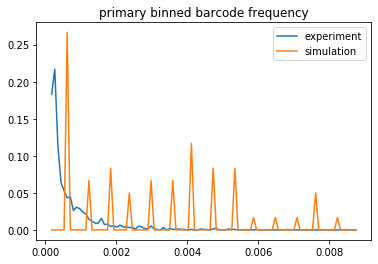

In [23]:
plt.plot(priBins[2:], exp[0], label = "experiment")
plt.plot(priBins[2:], simBarFreq["barcodeFrequency"][0], label = "simulation")
plt.title("primary binned barcode frequency")
plt.legend()
# plt.yscale('log')

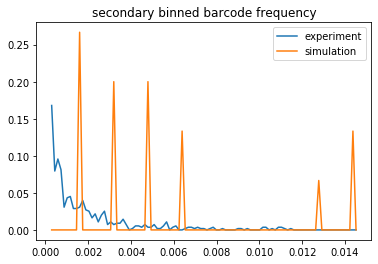

In [24]:
plt.plot(secBins[2:], exp[1], label = "experiment")
plt.plot(secBins[2:], simBarFreq["barcodeFrequency"][1], label = "simulation")
plt.title("secondary binned barcode frequency")
plt.legend()

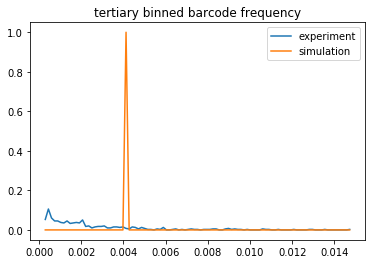

In [25]:
plt.plot(terBins[2:], exp[2], label = "experiment")
plt.plot(terBins[2:], simBarFreq["barcodeFrequency"][2], label = "simulation")
plt.title("tertiary binned barcode frequency")
plt.legend()

In [26]:
def ksStatistic(o,m):
    #print("%dx%d\n" % (len(o), len(m)) )
    k,p = stats.ks_2samp(o,m)
    return(k)

def distancePopulation(summStat,sim,data):
    modelResults = sim["barcodeFrequency"]
    observations = data["barcodeFrequency"] 
    results = [summStat(observations[i],modelResults[i]) for i in range(len(observations))]
#     print(sum(results))
    return(sum(results))


In [27]:
distancePopulation(ksStatistic, simBarFreq, expBarFreq)

1.5858585858585859

Now we are search for the best fitting parameters using pyABC.

In [28]:
# limits = dict(k3 = (0, 0.15), 
#               k6 = (0, 0.16), 
#               k8 = (0, 0.55))

# parameter_prior = Distribution(**{key: RV("uniform", a, b - a)
#                         for key, (a,b) in limits.items()})

# db_path = pyabc.create_sqlite_db_id(file_ = "glioblatomaNewModel.db")

# abc = ABCSMC(models = determineTestParameters,
#              parameter_priors = parameter_prior,
#              distance_function = partial(distancePopulation,ksStatistic), 
#              population_size=50,
#              transitions=LocalTransition(k_fraction=.3))

# abc.new(db_path, expBarFreq);

In [29]:
# h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

In [30]:
# for t in range(h.max_t+1):
#     ax = plot_kde_2d(*h.get_distribution(m=0, t=t),
#                      "r", "rho",
#                 xmin=0, xmax=0.2, numx=300,
#                 ymin=0, ymax=0.8, numy=300)
#     ax.set_title("Posterior t={}".format(t))

In [31]:
# from pyabc.visualization import plot_kde_matrix

# df, w = h.get_distribution(m=0)
# plot_kde_matrix(df, w, limits=limits);